#### PROJET 5

Projet : https://openclassrooms.com/fr/projects/630/assignment données : https://www.kaggle.com/olistbr/brazilian-ecommerce

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.
Livrables

Un notebook de l'analyse exploratoire (non cleané, pour comprendre votre démarche).
Un notebook (ou code commenté au choix) d’essais des différentes approches de modélisation (non cleané, pour comprendre votre démarche).
Un support de présentation pour la soutenance.

### Import de données 

In [7]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import math
import random
import pickle
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV
from scipy import stats,spatial
import folium 
from folium.plugins import (FastMarkerCluster, Fullscreen, MiniMap,
                            HeatMap, HeatMapWithTime, LocateControl)

In [8]:
customers = pd.read_csv('https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/data/olist_customers_dataset.csv')
geolocalisation = pd.read_csv('https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/data/olist_geolocation_dataset.csv')
order_items = pd.read_csv('https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/data/olist_order_items_dataset.csv')
order_payments = pd.read_csv('https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/data/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/data/olist_order_reviews_dataset.csv')
orders = pd.read_csv('https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/data/olist_orders_dataset.csv')
products = pd.read_csv('https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/data/olist_products_dataset.csv')
sellers = pd.read_csv('https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/data/olist_sellers_dataset.csv')
product_category = pd.read_csv('https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/data/product_category_name_translation.csv')

### Connaissance du jeu de données et Nettoyage

In [9]:
liste_df = [customers, 
            geolocalisation,
            order_items,
            order_payments,
            order_reviews,
            orders,
            products,
            sellers,
            product_category]

In [10]:
noms_df = ['customers', 
           'geolocalisation',
           'order_items',
           'order_payments',
           'order_reviews',
           'orders',
           'products',
           'sellers',
           'product_category']

In [11]:
for df in liste_df :
    print(df.shape)

(99441, 5)
(1000163, 5)
(112650, 7)
(103886, 5)
(99224, 7)
(99441, 8)
(32951, 9)
(3095, 4)
(71, 2)


Dans cette étape nous avons vu les tailles et les dimensiosn de chacune de nos bases de données. 

## Type de données 

In [12]:
i=0
liste_indices = []
liste_colonnes = []
liste_types = []
liste_uniques = []

for df in liste_df:

    for column in df.columns:
        liste_indices.append(noms_df[i])
        liste_colonnes.append(column)
        liste_types.append(df[column].dtype)
        liste_uniques.append(df[column].nunique())
    i+=1
resume_data = pd.DataFrame([liste_indices, 
                            liste_colonnes, 
                            liste_types, 
                            liste_uniques]
                          ).T
resume_data.columns=['Donnees', 'Nom colonne', 'Type', 'valeurs uniques']
resume_data

Donnees                    Nom colonne     Type valeurs uniques
0          customers                    customer_id   object           99441
1          customers             customer_unique_id   object           96096
2          customers       customer_zip_code_prefix    int64           14994
3          customers                  customer_city   object            4119
4          customers                 customer_state   object              27
5    geolocalisation    geolocation_zip_code_prefix    int64           19015
6    geolocalisation                geolocation_lat  float64          717360
7    geolocalisation                geolocation_lng  float64          717613
8    geolocalisation               geolocation_city   object            8011
9    geolocalisation              geolocation_state   object              27
10       order_items                       order_id   object           98666
11       order_items                  order_item_id    int64              21
12       order_items                     product_id   object           32951
13       order_items                      seller_id   object            3095
14       order_items            shipping_limit_date   object           93318
15       order_items                          price  float64            5968
16       order_items                  freight_value  float64            6999
17    order_payments                       order_id   object           99440
18    order_payments             payment_sequential    int64              29
19    order_payments                   payment_type   object               5
20    order_payments           payment_installments    int64              24
21    order_payments                  payment_value  float64           29077
22     order_reviews                      review_id   object           98410
23     order_reviews                       order_id   object           98673
24     order_reviews                   review_score    int64               5
25     order_reviews           review_comment_title   object            4527
26     order_reviews         review_comment_message   object           36159
27     order_reviews           review_creation_date   object             636
28     order_reviews        review_answer_timestamp   object           98248
29            orders                       order_id   object           99441
30            orders                    customer_id   object           99441
31            orders                   order_status   object               8
32            orders       order_purchase_timestamp   object           98875
33            orders              order_approved_at   object           90733
34            orders   order_delivered_carrier_date   object           81018
35            orders  order_delivered_customer_date   object           95664
36            orders  order_estimated_delivery_date   object             459
37          products                     product_id   object           32951
38          products          product_category_name   object              73
39          products            product_name_lenght  float64              66
40          products     product_description_lenght  float64            2960
41          products             product_photos_qty  float64              19
42          products               product_weight_g  float64            2204
43          products              product_length_cm  float64              99
44          products              product_height_cm  float64             102
45          products               product_width_cm  float64              95
46           sellers                      seller_id   object            3095
47           sellers         seller_zip_code_prefix    int64            2246
48           sellers                    seller_city   object             611
49           sellers                   seller_state   object              23
50  product_category          product_category_name   object              71
51  produ

### Valeurs dupliquer 

In [13]:
for df in liste_df:
    print(df.duplicated().sum())

0
261831
0
0
0
0
0
0
0


In [14]:
customers.head(3)

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP

In [15]:
customers.groupby('customer_unique_id')[['customer_id']]\
    .count().sort_values(by='customer_id', ascending=False).nlargest(5,'customer_id') # On garde que les 5 premières lignes

customer_id
customer_unique_id                           
8d50f5eadf50201ccdcedfb9e2ac8455           17
3e43e6105506432c953e165fb2acf44c            9
6469f99c1f9dfae7733b25662e7f1782            7
ca77025e7201e3b30c44b472ff346268            7
1b6c7548a2a1f9037c1fd3ddfed95f33            7

Nous allons visualiser la répartition des clients dans le villes.

In [16]:
print("Nombre de valeur (sans doublons) de chaque colonne \n")
customers.nunique()

Nombre de valeur (sans doublons) de chaque colonne 



customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

Les 10 des villes ayant le plus de clients

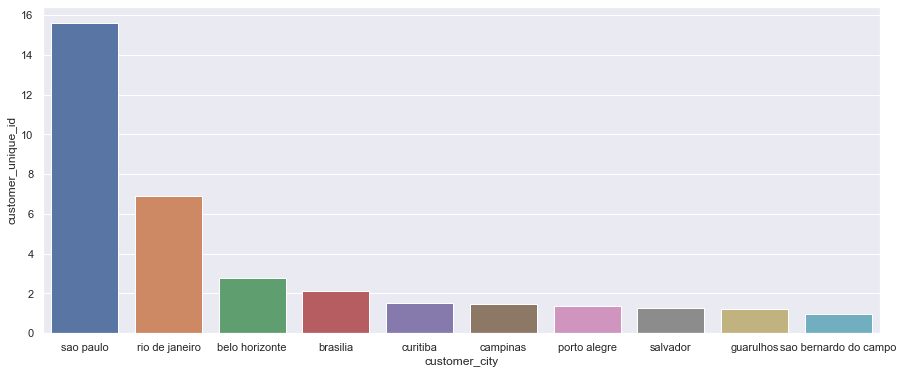

In [17]:
#Nombre de client par ville
df=pd.DataFrame(customers.groupby('customer_city')['customer_unique_id']
                        .count().reset_index())
#Pourcentage de client par ville 
df['customer_unique_id']= df['customer_unique_id']/( len(customers['customer_unique_id']))*100

#Top 5 des villes qui contiennent plus de clients 
df = df.nlargest(10,'customer_unique_id')

#Tracé Barplot
plt.figure(figsize=(15, 6))
p=sns.barplot(x='customer_city', y="customer_unique_id", data=df )
#show_values(p)

Les 10 des états ayant le plus de clients

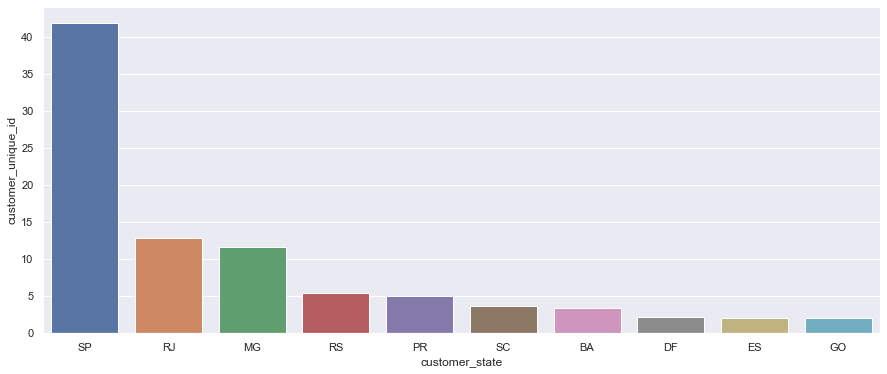

In [18]:
#Nombre de client par etat
df=pd.DataFrame(customers.groupby('customer_state')['customer_unique_id']
                        .count().reset_index())
#Pourcentage de client par etat
df['customer_unique_id']= df['customer_unique_id']/( len(customers['customer_unique_id']))*100

#Top 5 des villes qui contiennent plus de clients 
df = df.nlargest(10,'customer_unique_id')

#Tracé Barplot
plt.figure(figsize=(15, 6))
p=sns.barplot(x='customer_state', y="customer_unique_id", data=df )
#show_values(p)

Les 10 des codes postaux où il y a plus de clients

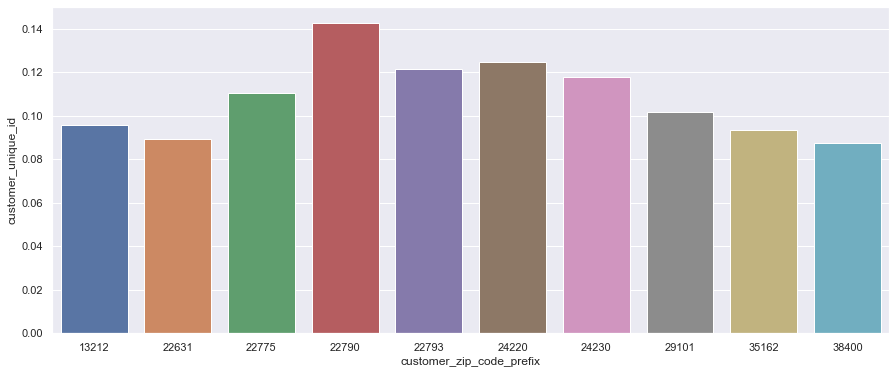

In [19]:
#Nombre de client par etat
df=pd.DataFrame(customers.groupby('customer_zip_code_prefix')['customer_unique_id']
                        .count().reset_index())
#Pourcentage de client par etat
df['customer_unique_id']= df['customer_unique_id']/( len(customers['customer_unique_id']))*100

#Top 5 des villes qui contiennent plus de clients 
df = df.nlargest(10,'customer_unique_id')

#Tracé Barplot
plt.figure(figsize=(15, 6))
p=sns.barplot(x='customer_zip_code_prefix', y="customer_unique_id", data=df )
#show_values(p)

La table Products

Il existe deux tables pour les produits : la table product et la table product_category.

In [20]:
products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [21]:
product_category.head()

product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

On va fusionner la product_category à la table product pour compléter la table product. C'est notre première jointure. Toutes les autres jointures vont être faites plus tard.

In [22]:
products = products.merge(product_category,
                          on='product_category_name',
                          how='left'
                          )

In [23]:
products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             225.0               16.0               10.0              14.0   
1            1000.0               30.0               18.0              20.0   
2             154.0               18.0                9.0              15.0   
3             371.0               26.0                4.0              26.0   
4             625.0               20.0               17.0              13.0   

  product_category_name_english  
0                     perfumery  
1                           art  
2                sports_leisure  
3                          baby  
4                    housewares

Valeurs manquantes de la table products

In [24]:
products.isnull().sum()

product_id                         0
product_category_name            610
product_name_lenght              610
product_description_lenght       610
product_photos_qty               610
product_weight_g                   2
product_length_cm                  2
product_height_cm                  2
product_width_cm                   2
product_category_name_english    623
dtype: int64

Les 10 des produits les plus présents dans la base de données

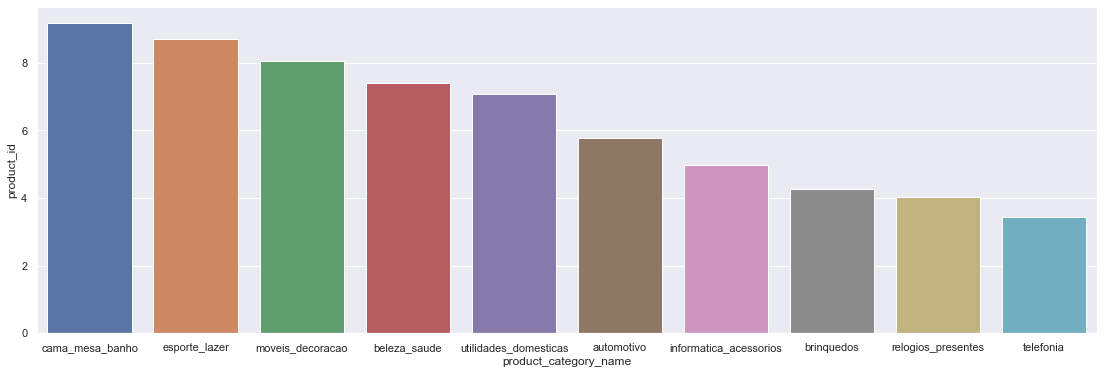

In [25]:
#Nombre de produits par client
df=pd.DataFrame(products.groupby('product_category_name')['product_id']
                        .count().reset_index())
#Pourcentage de client par etat
df['product_id']= df['product_id']/( len(products['product_id']))*100

#Top 5 des villes qui contiennent plus de clients 
df = df.nlargest(10,'product_id')

#Tracé Barplot
plt.figure(figsize=(19, 6))
p=sns.barplot(x='product_category_name', y="product_id", data=df )
#show_values(p)

La table Sellers

C'est la table des vendeurs

In [26]:
sellers.head()

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

Répartition des vendeurs selon les villes

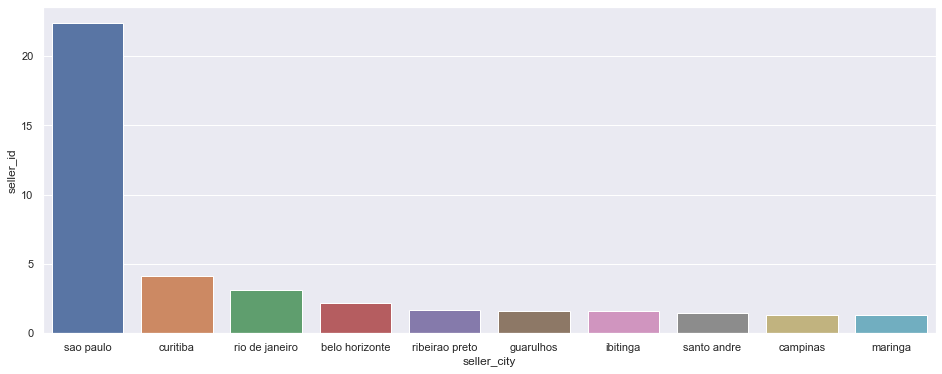

In [27]:
#Nombre de produits par client
df=pd.DataFrame(sellers.groupby('seller_city')['seller_id']
                        .count().reset_index())
#Pourcentage de client par etat
df['seller_id']= df['seller_id']/( len(sellers['seller_id']))*100

#Top 5 des villes qui contiennent plus de clients 
df = df.nlargest(10,'seller_id')

#Tracé Barplot
plt.figure(figsize=(16, 6))
p=sns.barplot(x='seller_city', y="seller_id", data=df )
#show_values(p)

Localisation des sellers

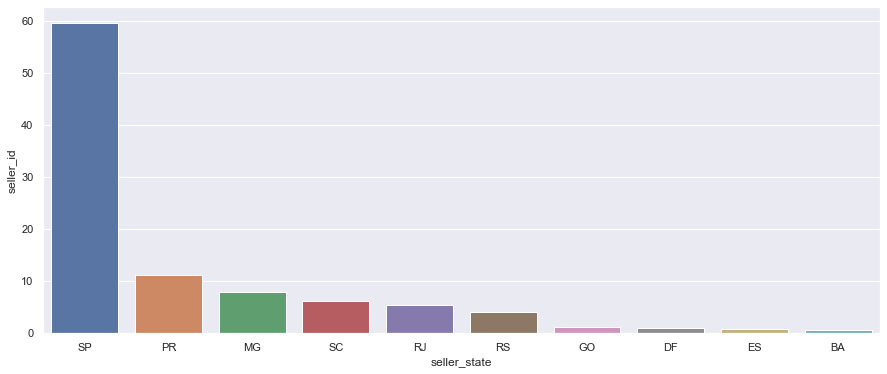

In [28]:
#Nombre de produits par client
df=pd.DataFrame(sellers.groupby('seller_state')['seller_id']
                        .count().reset_index())
#Pourcentage de client par etat
df['seller_id']= df['seller_id']/( len(sellers['seller_id']))*100

#Top 5 des villes qui contiennent plus de clients 
df = df.nlargest(10,'seller_id')

#Tracé Barplot
plt.figure(figsize=(15, 6))
p=sns.barplot(x='seller_state', y="seller_id", data=df )
#show_values(p)

Make this Notebook Trusted to load map: File -> Trust Notebook



In [29]:
sellers.isnull().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

La table Geolocation

Nous allons faire représentation spatiale des données de cette table.

In [30]:
geolocalisation.head(2)

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP

In [31]:
geolocation [geolocation['geolocation_zip_code_prefix']==1001	]

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
99                           1001       -23.549292       -46.633559   
206                          1001       -23.550498       -46.634338   
235                          1001       -23.550642       -46.634410   
299                          1001       -23.549698       -46.633909   
326                          1001       -23.551427       -46.634074   
429                          1001       -23.550498       -46.634338   
519                          1001       -23.551337       -46.634027   
575                          1001       -23.549779       -46.633957   
583                          1001       -23.551337       -46.634027   
596                          1001       -23.550498       -46.634338   
608                          1001       -23.550263       -46.634196   
639                          1001       -23.550498       -46.634338   
771                          1001       -23.550498       -46.634338   
818                          1001       -23.551337       -46.634027   
851                          1001       -23.549825       -46.633970   
864                          1001       -23.549825       -46.633970   
897                          1001       -23.549292       -46.633559   
912                          1001       -23.550498       -46.634338   
985                          1001       -23.550498       -46.634338   
1004                         1001       -23.549292       -46.633559   
1062                         1001       -23.550498       -46.634338   
1182                         1001       -23.549779       -46.633957   
1246                         1001       -23.549292       -46.633559   
1351                         1001       -23.549951       -46.634027   
1384                         1001       -23.549292       -46.633559   
1435                         1001       -23.549292       -46.633559   

     geolocation_city geolocation_state  
99          sao paulo                SP  
206         sao paulo                SP  
235         sao paulo                SP  
299         sao paulo                SP  
326         sao paulo                SP  
429         sao paulo                SP  
519         sao paulo                SP  
575         são paulo                SP  
583         sao paulo                SP  
596         sao paulo                SP  
608         são paulo                SP  
639         sao paulo                SP  
771         sao paulo                SP  
818         sao paulo                SP  
851         sao paulo                SP  
864         sao paulo                SP  
897         sao paulo                SP  
912         sao paulo                SP  
985         sao paulo                SP  
1004        sao paulo                SP  
1062        sao paulo                SP  
1182        sao paulo                SP  
1246        sao paulo                SP  
1351        são paulo                SP  
1384        sao paulo                SP  
1435        sao paulo                SP

In [32]:
coordinate=geolocation.groupby('geolocation_zip_code_prefix')[
    ['geolocation_lat', 'geolocation_lng']].agg(lambda x:x.value_counts().index[0]).reset_index()
    
#On change les noms de colonne 
coordinate.columns = ['customer_zip_code_prefix', 'latitude', 'longitude']

In [33]:
cust_loc = customers.merge(coordinate,
                               on='customer_zip_code_prefix',
                               how='inner')

In [34]:
cust_loc.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
latitude                    0
longitude                   0
dtype: int64

In [35]:
# Aggregation des longitudes et latitude 
latitude = cust_loc['latitude'].to_list()
longitude = cust_loc['longitude'].to_list()
position = list(zip(latitude, longitude))

# Création de la carte folium
carte = folium.Map(location=[-14, -49], zoom_start=3.8)

# Utilisation de FastMarkerCluster
FastMarkerCluster(data=position).add_to(carte)

carte

In [36]:
coordinate1=geolocation.groupby('geolocation_zip_code_prefix')[
    ['geolocation_lat', 'geolocation_lng']].agg(lambda x:x.value_counts().index[0]).reset_index()
    
#On change les noms de colonne 
coordinate1.columns = ['seller_zip_code_prefix', 'latitude', 'longitude']

sellers_loc = sellers.merge(coordinate1,
                               on='seller_zip_code_prefix',
                               how='inner')

# Aggregation des longitudes et latitude 
latitude = sellers_loc['latitude'].to_list()
longitude = sellers_loc['longitude'].to_list()
position = list(zip(latitude, longitude))

# Création de la carte folium
carte = folium.Map(location=[-14, -49], zoom_start=3.8)

# Utilisation de FastMarkerCluster
FastMarkerCluster(data=position).add_to(carte)

carte

La table Orders

In [37]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [38]:
order_items.head(2)

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   

   shipping_limit_date  price  freight_value  
0  2017-09-19 09:45:35   58.9          13.29  
1  2017-05-03 11:05:13  239.9          19.93

In [39]:
order_items['shipping_limit_date'] = pd.to_datetime(
    order_items['shipping_limit_date'])

In [40]:
#Verifier si il y a des doublons dans la colonne order_id
len(set(order_items["order_id"])) == len(order_items["order_id"]) # Résultat = False si doublon il y a

False

In [41]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [42]:
order_payments.head(2)

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39

In [43]:
#Différents mode de de payment
set(order_payments['payment_type'])

{'boleto', 'credit_card', 'debit_card', 'not_defined', 'voucher'}

In [44]:
order_payments['payment_type'] = order_payments['payment_type'].replace(
    ['boleto', 'voucher'], ['billet', 'bon achat'])

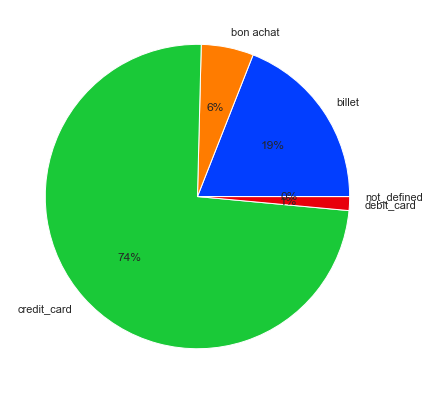

In [45]:
#Nombre de produits par client
df=pd.DataFrame(order_payments.groupby('payment_type')['order_id']
                        .count().reset_index())
palette_color = sns.color_palette('bright')

plt.figure(figsize=(9, 7))
# plotting data on chart
plt.pie(df['order_id'], labels=df['payment_type'], colors=palette_color, autopct='%.0f%%')
plt.show()

In [46]:
order_payments[order_payments['payment_type'] == 'not_defined']

order_id  payment_sequential payment_type  \
51280  4637ca194b6387e2d538dc89b124b0ee                   1  not_defined   
57411  00b1cb0320190ca0daa2c88b35206009                   1  not_defined   
94427  c8c528189310eaa44a745b8d9d26908b                   1  not_defined   

       payment_installments  payment_value  
51280                     1            0.0  
57411                     1            0.0  
94427                     1            0.0

In [47]:
order_payments=order_payments[order_payments['payment_type'] != 'not_defined']

In [48]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [49]:
order_reviews.head(2)

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   

   review_score review_comment_title review_comment_message  \
0             4                  NaN                    NaN   
1             5                  NaN                    NaN   

  review_creation_date review_answer_timestamp  
0  2018-01-18 00:00:00     2018-01-18 21:46:59  
1  2018-03-10 00:00:00     2018-03-11 03:05:13

In [50]:
#Conversion des colonnes dates
order_reviews['review_creation_date'] = pd.to_datetime(
    order_reviews['review_creation_date'])
order_reviews['review_answer_timestamp'] = pd.to_datetime(
    order_reviews['review_answer_timestamp'])

In [51]:
order_reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [52]:
#Verifier si il y a des doublons dans la colonne order_id
len(set(order_reviews["review_id"])) == len(order_reviews["review_id"]) # Résultat = False si doublon il y a

False

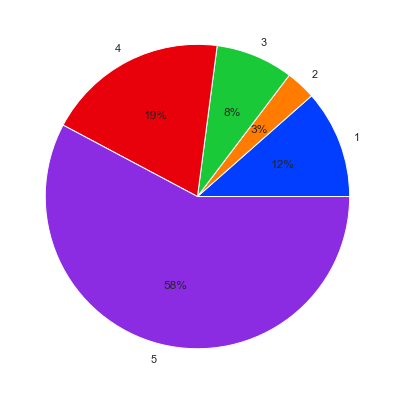

In [53]:
#Répartition des notes 
df=pd.DataFrame(order_reviews.groupby('review_score')['review_id']
                        .count().reset_index())
palette_color = sns.color_palette('bright')

plt.figure(figsize=(9, 7))
# plotting data on chart
plt.pie(df['review_id'], labels=df['review_score'], colors=palette_color, autopct='%.0f%%')
plt.show()

In [54]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [55]:
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

Cette table contient une colonne date. Nous allons convertir cette colonne en datetime.

In [56]:
#Conversion des colonnes dates
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])

orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])

orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

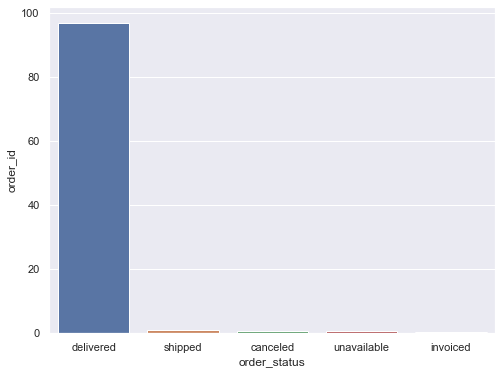

In [57]:
##Répartition des status de commande
df=pd.DataFrame(orders.groupby('order_status')['order_id']
                        .count().reset_index())
#Pourcentage de client par etat
df['order_id']= df['order_id']/( len(orders['order_id']))*100

#Top 5 des villes qui contiennent plus de clients 
df = df.nlargest(5,'order_id')

#Tracé Barplot
plt.figure(figsize=(8, 6))
p=sns.barplot(x='order_status', y="order_id", data=df )
#show_values(p)

In [58]:
orders = orders[orders['order_status'] == 'delivered']

In [59]:
order_copy=orders.copy()
order_copy['order_purchase_timestamp'] = pd.to_datetime(order_copy["order_purchase_timestamp"].dt.strftime('%Y-%m'))
order_copy.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered               2017-10-01 2017-10-02 11:07:15   
1    delivered               2018-07-01 2018-07-26 03:24:27   
2    delivered               2018-08-01 2018-08-08 08:55:23   
3    delivered               2017-11-01 2017-11-18 19:45:59   
4    delivered               2018-02-01 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04  
3                    2017-12-15  
4                    2018-02-26

In [60]:
order_copy['order_year'] = order_copy["order_purchase_timestamp"].dt.year  # Extraction des années
order_copy['order_month'] = order_copy["order_purchase_timestamp"].apply(lambda x: x.strftime('%B')) #Extraction des mois 
order_copy['order_day'] = order_copy["order_purchase_timestamp"].apply(lambda x: x.strftime("%A")) #Extraction des jours

In [61]:
"""order_copy['order_day'] = order_copy["order_purchase_timestamp"].dt.dayofweek # Extraction des jours de la semaine

# Créer un dictionnaire pour mapper les numéros de jour aux noms de jour
jours = {0: 'Lundi', 1: 'Mardi', 2: 'Mercredi', 3: 'Jeudi', 4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'}
# Appliquer la fonction de mapping à la colonne "Jour_Num" pour créer la nouvelle colonne "Nom_Jour"
order_copy['order_day_name'] = order_copy['order_day'].map(jours)"""

'order_copy[\'order_day\'] = order_copy["order_purchase_timestamp"].dt.dayofweek # Extraction des jours de la semaine\n\n# Créer un dictionnaire pour mapper les numéros de jour aux noms de jour\njours = {0: \'Lundi\', 1: \'Mardi\', 2: \'Mercredi\', 3: \'Jeudi\', 4: \'Vendredi\', 5: \'Samedi\', 6: \'Dimanche\'}\n# Appliquer la fonction de mapping à la colonne "Jour_Num" pour créer la nouvelle colonne "Nom_Jour"\norder_copy[\'order_day_name\'] = order_copy[\'order_day\'].map(jours)'

In [62]:
order_copy = order_copy.set_index('order_purchase_timestamp')
df= pd.DataFrame(order_copy.groupby('order_purchase_timestamp')['customer_id'].agg('count'))

In [63]:
df.head()

customer_id
order_purchase_timestamp             
2016-09-01                          1
2016-10-01                        265
2016-12-01                          1
2017-01-01                        750
2017-02-01                       1653

In [64]:
order_copy

order_id  \
order_purchase_timestamp                                     
2017-10-01                e481f51cbdc54678b7cc49136f2d6af7   
2018-07-01                53cdb2fc8bc7dce0b6741e2150273451   
2018-08-01                47770eb9100c2d0c44946d9cf07ec65d   
2017-11-01                949d5b44dbf5de918fe9c16f97b45f8a   
2018-02-01                ad21c59c0840e6cb83a9ceb5573f8159   
...                                                    ...   
2017-03-01                9c5dedf39a927c1b2549525ed64a053c   
2018-02-01                63943bddc261676b46f01ca7ac2f7bd8   
2017-08-01                83c1379a015df1e13d02aae0204711ab   
2018-01-01                11c177c8e97725db2631073c19f07b62   
2018-03-01                66dea50a8b16d9b4dee7af250b4be1a5   

                                               customer_id order_status  \
order_purchase_timestamp                                                  
2017-10-01                9ef432eb6251297304e76186b10a928d    delivered   
2018-07-01                b0830fb4747a6c6d20dea0b8c802d7ef    delivered   
2018-08-01                41ce2a54c0b03bf3443c3d931a367089    delivered   
2017-11-01                f88197465ea7920adcdbec7375364d82    delivered   
2018-02-01                8ab97904e6daea8866dbdbc4fb7aad2c    delivered   
...                                                    ...          ...   
2017-03-01                39bd1228ee8140590ac3aca26f2dfe00    delivered   
2018-02-01                1fca14ff2861355f6e5f14306ff977a7    delivered   
2017-08-01                1aa71eb042121263aafbe80c1b562c9c    delivered   
2018-01-01                b331b74b18dc79bcdf6532d51e1637c1    delivered   
2018-03-01                edb027a75a1449115f6b43211ae02a24    delivered   

                           order_approved_at order_delivered_carrier_date  \
order_purchase_timestamp                                                    
2017-10-01               2017-10-02 11:07:15          2017-10-04 19:55:00   
2018-07-01               2018-07-26 03:24:27          2018-07-26 14:31:00   
2018-08-01               2018-08-08 08:55:23          2018-08-08 13:50:00   
2017-11-01               2017-11-18 19:45:59          2017-11-22 13:39:59   
2018-02-01               2018-02-13 22:20:29          2018-02-14 19:46:34   
...                                      ...                          ...   
2017-03-01               2017-03-09 09:54:05          2017-03-10 11:18:03   
2018-02-01               2018-02-06 13:10:37          2018-02-07 23:22:42   
2017-08-01               2017-08-27 15:04:16          2017-08-28 20:52:26   
2018-01-01               2018-01-08 21:36:21          2018-01-12 15:35:03   
2018-03-01               2018-03-09 11:20:28          2018-03-09 22:11:59   

                         order_delivered_customer_date  \
order_purchase_timestamp                                 
2017-10-01                         2017-10-10 21:25:13   
2018-07-01                         2018-08-07 15:27:45   
2018-08-01                         2018-08-17 18:06:29   
2017-11-01                         2017-12-02 00:28:42   
2018-02-01                         2018-02-16 18:17:02   
...                                                ...   
2017-03-01                         2017-03-17 15:08:01   
2018-02-01                         2018-02-28 17:37:56   
2017-08-01                         2017-09-21 11:24:17   
2018-01-01                         2018-01-25 23:32:54   
2018-03-01                         2018-03-16 13:08:30   

                         order_estimated_delivery_date  order_year  \
order_purchase_timestamp                                             
2017-10-01                                  2017-10-18        2017   
2018-07-01                                  2018-08-13        2018   
2018-08-01                                  2018-09-04        2018   
2017-11-01                                  2017-12-15        2017   
2018-02-01                                  2018-02-26        2018   
...                 

In [65]:
order_copy

order_id  \
order_purchase_timestamp                                     
2017-10-01                e481f51cbdc54678b7cc49136f2d6af7   
2018-07-01                53cdb2fc8bc7dce0b6741e2150273451   
2018-08-01                47770eb9100c2d0c44946d9cf07ec65d   
2017-11-01                949d5b44dbf5de918fe9c16f97b45f8a   
2018-02-01                ad21c59c0840e6cb83a9ceb5573f8159   
...                                                    ...   
2017-03-01                9c5dedf39a927c1b2549525ed64a053c   
2018-02-01                63943bddc261676b46f01ca7ac2f7bd8   
2017-08-01                83c1379a015df1e13d02aae0204711ab   
2018-01-01                11c177c8e97725db2631073c19f07b62   
2018-03-01                66dea50a8b16d9b4dee7af250b4be1a5   

                                               customer_id order_status  \
order_purchase_timestamp                                                  
2017-10-01                9ef432eb6251297304e76186b10a928d    delivered   
2018-07-01                b0830fb4747a6c6d20dea0b8c802d7ef    delivered   
2018-08-01                41ce2a54c0b03bf3443c3d931a367089    delivered   
2017-11-01                f88197465ea7920adcdbec7375364d82    delivered   
2018-02-01                8ab97904e6daea8866dbdbc4fb7aad2c    delivered   
...                                                    ...          ...   
2017-03-01                39bd1228ee8140590ac3aca26f2dfe00    delivered   
2018-02-01                1fca14ff2861355f6e5f14306ff977a7    delivered   
2017-08-01                1aa71eb042121263aafbe80c1b562c9c    delivered   
2018-01-01                b331b74b18dc79bcdf6532d51e1637c1    delivered   
2018-03-01                edb027a75a1449115f6b43211ae02a24    delivered   

                           order_approved_at order_delivered_carrier_date  \
order_purchase_timestamp                                                    
2017-10-01               2017-10-02 11:07:15          2017-10-04 19:55:00   
2018-07-01               2018-07-26 03:24:27          2018-07-26 14:31:00   
2018-08-01               2018-08-08 08:55:23          2018-08-08 13:50:00   
2017-11-01               2017-11-18 19:45:59          2017-11-22 13:39:59   
2018-02-01               2018-02-13 22:20:29          2018-02-14 19:46:34   
...                                      ...                          ...   
2017-03-01               2017-03-09 09:54:05          2017-03-10 11:18:03   
2018-02-01               2018-02-06 13:10:37          2018-02-07 23:22:42   
2017-08-01               2017-08-27 15:04:16          2017-08-28 20:52:26   
2018-01-01               2018-01-08 21:36:21          2018-01-12 15:35:03   
2018-03-01               2018-03-09 11:20:28          2018-03-09 22:11:59   

                         order_delivered_customer_date  \
order_purchase_timestamp                                 
2017-10-01                         2017-10-10 21:25:13   
2018-07-01                         2018-08-07 15:27:45   
2018-08-01                         2018-08-17 18:06:29   
2017-11-01                         2017-12-02 00:28:42   
2018-02-01                         2018-02-16 18:17:02   
...                                                ...   
2017-03-01                         2017-03-17 15:08:01   
2018-02-01                         2018-02-28 17:37:56   
2017-08-01                         2017-09-21 11:24:17   
2018-01-01                         2018-01-25 23:32:54   
2018-03-01                         2018-03-16 13:08:30   

                         order_estimated_delivery_date  order_year  \
order_purchase_timestamp                                             
2017-10-01                                  2017-10-18        2017   
2018-07-01                                  2018-08-13        2018   
2018-08-01                                  2018-09-04        2018   
2017-11-01                                  2017-12-15        2017   
2018-02-01                                  2018-02-26        2018   
...                 

In [66]:
df

customer_id
order_purchase_timestamp             
2016-09-01                          1
2016-10-01                        265
2016-12-01                          1
2017-01-01                        750
2017-02-01                       1653
2017-03-01                       2546
2017-04-01                       2303
2017-05-01                       3546
2017-06-01                       3135
2017-07-01                       3872
2017-08-01                       4193
2017-09-01                       4150
2017-10-01                       4478
2017-11-01                       7289
2017-12-01                       5513
2018-01-01                       7069
2018-02-01                       6555
2018-03-01                       7003
2018-04-01                       6798
2018-05-01                       6749
2018-06-01                       6099
2018-07-01                       6159
2018-08-01                       6351

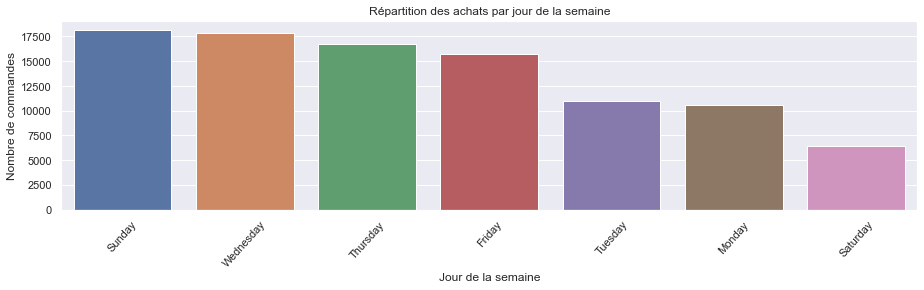

In [67]:
plt.figure(figsize=(13,4))
#order = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]
order = set (order_copy['order_day'])
order = sorted(order, key=lambda x: order_copy[order_copy['order_day'] == x].shape[0], reverse=True)
sns.countplot(x="order_day", data=order_copy, order=order)
# Tracer la distribution des catégories
#plt.xticks(rotation=45)
sns.set(style="darkgrid")
plt.xticks(rotation=48)
plt.tight_layout()  # Ajouter cette ligne
plt.title('Répartition des achats par jour de la semaine')
plt.xlabel('Jour de la semaine')
plt.ylabel('Nombre de commandes')

plt.show()

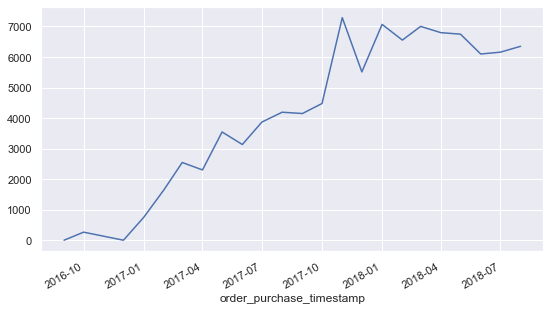

In [68]:
plt.figure(figsize=(9, 5))
df['customer_id'].plot()
plt.show()

In [69]:
order_copy.head()

order_id  \
order_purchase_timestamp                                     
2017-10-01                e481f51cbdc54678b7cc49136f2d6af7   
2018-07-01                53cdb2fc8bc7dce0b6741e2150273451   
2018-08-01                47770eb9100c2d0c44946d9cf07ec65d   
2017-11-01                949d5b44dbf5de918fe9c16f97b45f8a   
2018-02-01                ad21c59c0840e6cb83a9ceb5573f8159   

                                               customer_id order_status  \
order_purchase_timestamp                                                  
2017-10-01                9ef432eb6251297304e76186b10a928d    delivered   
2018-07-01                b0830fb4747a6c6d20dea0b8c802d7ef    delivered   
2018-08-01                41ce2a54c0b03bf3443c3d931a367089    delivered   
2017-11-01                f88197465ea7920adcdbec7375364d82    delivered   
2018-02-01                8ab97904e6daea8866dbdbc4fb7aad2c    delivered   

                           order_approved_at order_delivered_carrier_date  \
order_purchase_timestamp                                                    
2017-10-01               2017-10-02 11:07:15          2017-10-04 19:55:00   
2018-07-01               2018-07-26 03:24:27          2018-07-26 14:31:00   
2018-08-01               2018-08-08 08:55:23          2018-08-08 13:50:00   
2017-11-01               2017-11-18 19:45:59          2017-11-22 13:39:59   
2018-02-01               2018-02-13 22:20:29          2018-02-14 19:46:34   

                         order_delivered_customer_date  \
order_purchase_timestamp                                 
2017-10-01                         2017-10-10 21:25:13   
2018-07-01                         2018-08-07 15:27:45   
2018-08-01                         2018-08-17 18:06:29   
2017-11-01                         2017-12-02 00:28:42   
2018-02-01                         2018-02-16 18:17:02   

                         order_estimated_delivery_date  order_year  \
order_purchase_timestamp                                             
2017-10-01                                  2017-10-18        2017   
2018-07-01                                  2018-08-13        2018   
2018-08-01                                  2018-09-04        2018   
2017-11-01                                  2017-12-15        2017   
2018-02-01                                  2018-02-26        2018   

                         order_month  order_day  
order_purchase_timestamp                         
2017-10-01                   October     Sunday  
2018-07-01                      July     Sunday  
2018-08-01                    August  Wednesday  
2017-11-01                  November  Wednesday  
2018-02-01                  February   Thursday

In [70]:
!pip install sorted-months-weekdays
!pip install sort-dataframeby-monthorweek

In [71]:
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *

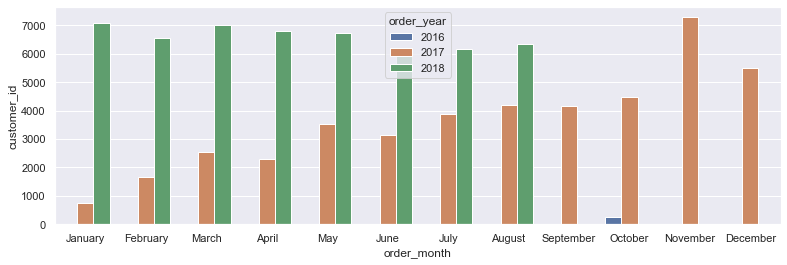

In [72]:
plt.figure(figsize=(13,4))
tmp1 = pd.DataFrame(order_copy.groupby(['order_month','order_year'])[['customer_id']].agg('count').reset_index())
# On tri par ordre mensuel
tmp1 = Sort_Dataframeby_Month(df=tmp1,monthcolumnname='order_month')
#Taracé du graphique
sns.barplot(data=tmp1, x="order_month", y="customer_id", hue="order_year")
plt.show()

On peut d'après ce graphique comparer les achats effectués en 2016 et 2017.

Nous allons une grande table regroupant les clients et leurs informations sur chacun de leur achat.


In [73]:
custumers_position = customers.merge(coordinate,
                               on='customer_zip_code_prefix',
                               how='inner')

In [74]:
customer_purchase_info = custumers_position.merge(orders, on='customer_id', how='inner')
customer_purchase_info  = customer_purchase_info.merge(order_items, on='order_id', how='inner')
customer_purchase_info  = customer_purchase_info.merge(order_reviews, on='order_id', how='inner')
customer_purchase_info  = customer_purchase_info.merge(order_payments, on='order_id', how='inner')
customer_purchase_info  = customer_purchase_info.merge(products, on='product_id', how='inner')

Dans cette table on peut trouver l'identifiant de chaque client, sa location ainsi que toutes les infos relatives à ses achats.

In [75]:
customer_purchase_info.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  97ee81fede5757f1ab031e83d1a59f56  452fab1c62b178922fc011b0eb89c1b9   
2  97ee81fede5757f1ab031e83d1a59f56  452fab1c62b178922fc011b0eb89c1b9   
3  44e25679aa4d5d2ef5103f6b0174a586  613259d64ba972e49dc25b019b7918c3   
4  ac318397fb90e64c9a724a3fc61ef587  aaad33c5051196b5e73c7d65b9072e1d   

   customer_zip_code_prefix customer_city customer_state   latitude  \
0                     14409        franca             SP -20.513713   
1                     47800     barreiras             BA -12.147031   
2                     47800     barreiras             BA -12.147031   
3                      6414       barueri             SP -23.495901   
4                     37137       alfenas             MG -21.407572   

   longitude                          order_id order_status  \
0 -47.396644  00e7ee1b050b8499577073aeb2a297a1    delivered   
1 -44.996092  a4866dfc455353f48014a2b9a86608a2    delivered   
2 -44.996092  a4866dfc455353f48014a2b9a86608a2    delivered   
3 -46.874687  03afb3c10af52ddfa3c33b9881bf43f8    delivered   
4 -45.943353  3c75044db750a89606612ed286713eb8    delivered   

  order_purchase_timestamp  ... payment_value product_category_name  \
0      2017-05-16 15:05:35  ...        146.87     moveis_escritorio   
1      2018-01-11 16:47:03  ...        340.50     moveis_escritorio   
2      2018-01-11 16:47:03  ...        340.50     moveis_escritorio   
3      2017-12-07 16:41:50  ...        131.50     moveis_escritorio   
4      2018-03-13 20:11:20  ...        100.00     moveis_escritorio   

  product_name_lenght product_description_lenght  product_photos_qty  \
0                41.0                     1141.0                 1.0   
1                41.0                     1141.0                 1.0   
2                41.0                     1141.0                 1.0   
3                41.0                     1141.0                 1.0   
4                41.0                     1141.0                 1.0   

  product_weight_g product_length_cm product_height_cm  product_width_cm  \
0           8683.0              54.0              64.0              31.0   
1           8683.0              54.0              64.0              31.0   
2           8683.0              54.0              64.0              31.0   
3           8683.0              54.0              64.0              31.0   
4           8683.0              54.0              64.0              31.0   

   product_category_name_english  
0               office_furniture  
1               office_furniture  
2               office_furniture  
3               office_furniture  
4               office_furniture  

[5 rows x 39 columns]

Observons les valeurs manquantes

In [76]:
order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value  
0 2017-09-19 09:45:35   58.90          13.29  
1 2017-05-03 11:05:13  239.90          19.93  
2 2018-01-18 14:48:30  199.00          17.87  
3 2018-08-15 10:10:18   12.99          12.79  
4 2017-02-13 13:57:51  199.90          18.14

In [77]:
customer_purchase_info.isnull().sum()

customer_id                           0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
latitude                              0
longitude                             0
order_id                              0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    15
order_delivered_carrier_date          2
order_delivered_customer_date         8
order_estimated_delivery_date         0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
review_id                             0
review_score                          0
review_comment_title             101017
review_comment_message            66588
review_creation_date                  0


In [78]:
customer_purchase_info.to_csv("customer_purchase_info.csv", index=False)

In [79]:
customer_purchase_info.shape

(114557, 39)

Le RFM est une technique d'analyse de la segmentation de la clientèle qui permet de classer les clients en fonction de leur comportement d'achat. Le nom RFM est un acronyme pour les trois critères utilisés dans cette analyse : Récence (R), Fréquence (F) et Montant (M).

    Récence (R) : mesure la date de la dernière transaction du client. Les clients qui ont effectué un achat plus récemment sont considérés comme plus précieux pour l'entreprise.

    Fréquence (F) : mesure le nombre de transactions effectuées par le client sur une période de temps donnée. Les clients qui effectuent plus d'achats sont considérés comme plus précieux pour l'entreprise.

    Montant (M) : mesure le montant total dépensé par le client sur une période de temps donnée. Les clients qui dépensent plus sont considérés comme plus précieux pour l'entreprise.

En combinant ces trois critères, on peut créer une matrice RFM qui classe les clients en fonction de leur valeur pour l'entreprise. Les clients qui ont des scores élevés en R, F et M sont considérés comme les plus précieux, tandis que les clients qui ont des scores plus faibles sont considérés comme moins précieux. Cette analyse peut aider les entreprises à mieux comprendre les comportements d'achat de leurs clients et à prendre des décisions stratégiques en matière de marketing et de gestion de la relation client.

Nous allons nous baser sur le RFM pour créer trois tables associées à chacune des mesures.

La table Récence

In [80]:
recency = customer_purchase_info[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').max().reset_index()


recency['recency'] = (
    (recency['order_purchase_timestamp'].max() -
     recency['order_purchase_timestamp']).dt.days)

recency = recency[["customer_unique_id","recency"]]
recency

customer_unique_id  recency
0      0000366f3b9a7992bf8c76cfdf3221e2      111
1      0000b849f77a49e4a4ce2b2a4ca5be3f      114
2      0000f46a3911fa3c0805444483337064      536
3      0000f6ccb0745a6a4b88665a16c9f078      320
4      0004aac84e0df4da2b147fca70cf8255      287
...                                 ...      ...
92496  fffcf5a5ff07b0908bd4e2dbc735a684      446
92497  fffea47cd6d3cc0a88bd621562a9d061      261
92498  ffff371b4d645b6ecea244b27531430a      567
92499  ffff5962728ec6157033ef9805bacc48      118
92500  ffffd2657e2aad2907e67c3e9daecbeb      483

[92501 rows x 2 columns]

La table fréquence

In [81]:
# Create a dataframe to store customers id and frequency scores
frequency = customer_purchase_info[['customer_unique_id', 'order_id']].groupby('customer_unique_id').count().reset_index()
frequency.rename(columns={"order_id":"frequency"}, inplace=True)
frequency

customer_unique_id  frequency
0      0000366f3b9a7992bf8c76cfdf3221e2          1
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1
2      0000f46a3911fa3c0805444483337064          1
3      0000f6ccb0745a6a4b88665a16c9f078          1
4      0004aac84e0df4da2b147fca70cf8255          1
...                                 ...        ...
92496  fffcf5a5ff07b0908bd4e2dbc735a684          2
92497  fffea47cd6d3cc0a88bd621562a9d061          1
92498  ffff371b4d645b6ecea244b27531430a          1
92499  ffff5962728ec6157033ef9805bacc48          1
92500  ffffd2657e2aad2907e67c3e9daecbeb          1

[92501 rows x 2 columns]

La table montant

In [82]:
montant = customer_purchase_info[['customer_unique_id', 'payment_value']].groupby('customer_unique_id').sum().reset_index()

montant.rename(columns={"payment_value":"monetary"}, inplace=True)
montant 

customer_unique_id  monetary
0      0000366f3b9a7992bf8c76cfdf3221e2    141.90
1      0000b849f77a49e4a4ce2b2a4ca5be3f     27.19
2      0000f46a3911fa3c0805444483337064     86.22
3      0000f6ccb0745a6a4b88665a16c9f078     43.62
4      0004aac84e0df4da2b147fca70cf8255    196.89
...                                 ...       ...
92496  fffcf5a5ff07b0908bd4e2dbc735a684   4134.84
92497  fffea47cd6d3cc0a88bd621562a9d061     84.58
92498  ffff371b4d645b6ecea244b27531430a    112.46
92499  ffff5962728ec6157033ef9805bacc48    133.69
92500  ffffd2657e2aad2907e67c3e9daecbeb     71.56

[92501 rows x 2 columns]

Une fois que l'on a obtenu les 3 indicateurs essentiels du RFM, nous allons recupérer d'autres indicateurs à partir des données comme le Review, frais de livraison, etc. Une fois tous indicateurs obtenus, nous allons créer une grande table regroupant toutes ces indicateurs.

In [83]:
segment_rfm = recency.merge(frequency, on='customer_unique_id', how='inner')
segment_rfm = segment_rfm.merge(montant, on='customer_unique_id', how='inner')
segment_rfm

customer_unique_id  recency  frequency  monetary
0      0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90
1      0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19
2      0000f46a3911fa3c0805444483337064      536          1     86.22
3      0000f6ccb0745a6a4b88665a16c9f078      320          1     43.62
4      0004aac84e0df4da2b147fca70cf8255      287          1    196.89
...                                 ...      ...        ...       ...
92496  fffcf5a5ff07b0908bd4e2dbc735a684      446          2   4134.84
92497  fffea47cd6d3cc0a88bd621562a9d061      261          1     84.58
92498  ffff371b4d645b6ecea244b27531430a      567          1    112.46
92499  ffff5962728ec6157033ef9805bacc48      118          1    133.69
92500  ffffd2657e2aad2907e67c3e9daecbeb      483          1     71.56

[92501 rows x 4 columns]

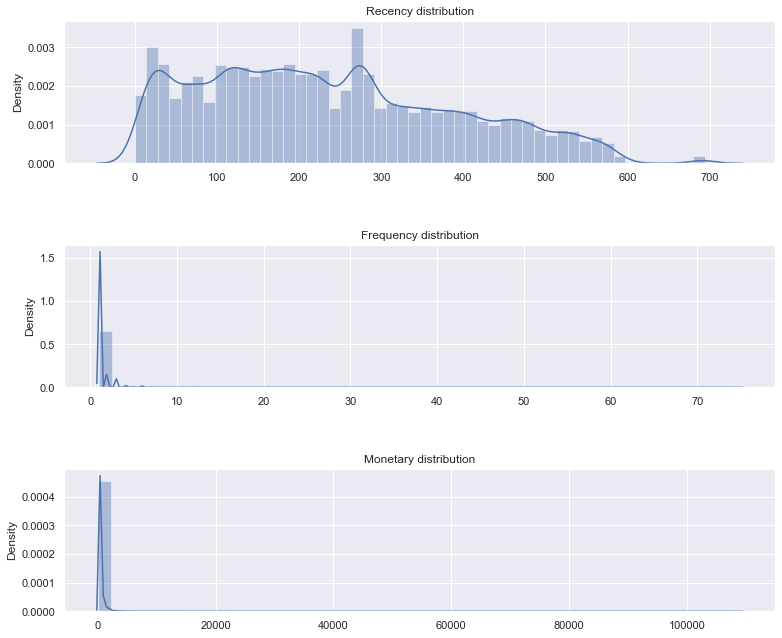

In [84]:
import warnings
warnings.simplefilter("ignore")

plt.figure(figsize=(12, 10))

#Recency
plt.subplot(3, 1, 1)
sns.distplot(segment_rfm['recency'])
plt.title('Recency distribution')
plt.xlabel(None)

#Frequency
plt.subplot(3, 1, 2)
sns.distplot(segment_rfm['frequency'])
plt.title('Frequency distribution')
plt.xlabel(None)

#Monetary
plt.subplot(3, 1, 3)
sns.distplot(segment_rfm['monetary'])
plt.title('Monetary distribution')
plt.xlabel(None)

plt.tight_layout(pad = 4)
plt.show()

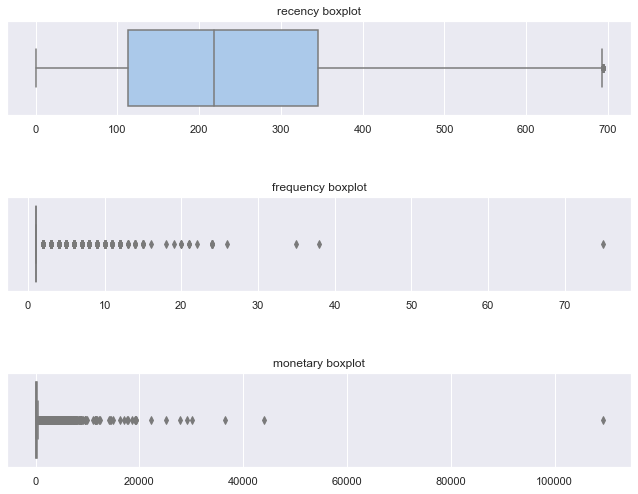

In [85]:
#Columns to examine
features = ['recency', 'frequency', 'monetary']

#Creating a boxplot for outlier detection
n = 1

plt.figure(figsize = (10, 8))

for feature in features:
    plt.subplot(3,1,n)
    sns.boxplot(segment_rfm[feature], palette = 'pastel').set(xlabel = None)
    plt.title(f'{feature} boxplot')
    n = n + 1
    
plt.tight_layout(pad = 4)

commentaire

In [86]:
note_com = customer_purchase_info[['customer_unique_id', 'review_score']].groupby('customer_unique_id').mean().reset_index()
note_com.rename(columns={"review_score":"note_com"}, inplace=True)
note_com #Table 1 : a ajouter dans la table finale

customer_unique_id  note_com
0      0000366f3b9a7992bf8c76cfdf3221e2       5.0
1      0000b849f77a49e4a4ce2b2a4ca5be3f       4.0
2      0000f46a3911fa3c0805444483337064       3.0
3      0000f6ccb0745a6a4b88665a16c9f078       4.0
4      0004aac84e0df4da2b147fca70cf8255       5.0
...                                 ...       ...
92496  fffcf5a5ff07b0908bd4e2dbc735a684       5.0
92497  fffea47cd6d3cc0a88bd621562a9d061       4.0
92498  ffff371b4d645b6ecea244b27531430a       5.0
92499  ffff5962728ec6157033ef9805bacc48       5.0
92500  ffffd2657e2aad2907e67c3e9daecbeb       5.0

[92501 rows x 2 columns]

Frais de livraison

In [87]:
frais_livraison = customer_purchase_info[['customer_unique_id', 'freight_value']].groupby('customer_unique_id').mean().reset_index()
frais_livraison.rename(columns={"freight_value":"frais_livraison"}, inplace=True)
frais_livraison #Table 2 : a ajouter dans la table finale

customer_unique_id  frais_livraison
0      0000366f3b9a7992bf8c76cfdf3221e2            12.00
1      0000b849f77a49e4a4ce2b2a4ca5be3f             8.29
2      0000f46a3911fa3c0805444483337064            17.22
3      0000f6ccb0745a6a4b88665a16c9f078            17.63
4      0004aac84e0df4da2b147fca70cf8255            16.89
...                                 ...              ...
92496  fffcf5a5ff07b0908bd4e2dbc735a684           248.71
92497  fffea47cd6d3cc0a88bd621562a9d061            19.69
92498  ffff371b4d645b6ecea244b27531430a            22.56
92499  ffff5962728ec6157033ef9805bacc48            18.69
92500  ffffd2657e2aad2907e67c3e9daecbeb            14.57

[92501 rows x 2 columns]

Durée moyen de livraison

In [88]:
t_moyen_livraison =  customer_purchase_info[['customer_unique_id', 'order_purchase_timestamp', 'order_delivered_customer_date']].groupby('customer_unique_id').mean().reset_index()
t_moyen_livraison['temps_moyen_livraison'] = (t_moyen_livraison['order_delivered_customer_date'] -t_moyen_livraison['order_purchase_timestamp']).dt.days

t_moyen_livraison =  t_moyen_livraison [['customer_unique_id','temps_moyen_livraison']]
t_moyen_livraison  #Table 3 : a ajouter dans la table finale

customer_unique_id  temps_moyen_livraison
0      0000366f3b9a7992bf8c76cfdf3221e2                    6.0
1      0000b849f77a49e4a4ce2b2a4ca5be3f                    3.0
2      0000f46a3911fa3c0805444483337064                   25.0
3      0000f6ccb0745a6a4b88665a16c9f078                   20.0
4      0004aac84e0df4da2b147fca70cf8255                   13.0
...                                 ...                    ...
92496  fffcf5a5ff07b0908bd4e2dbc735a684                   27.0
92497  fffea47cd6d3cc0a88bd621562a9d061                   30.0
92498  ffff371b4d645b6ecea244b27531430a                   14.0
92499  ffff5962728ec6157033ef9805bacc48                   11.0
92500  ffffd2657e2aad2907e67c3e9daecbeb                    7.0

[92501 rows x 2 columns]

In [89]:
t_moyen_livraison.isnull().sum() # Faut penser à supprimer les valeurs manquantes 

customer_unique_id       0
temps_moyen_livraison    8
dtype: int64

Localisation

In [90]:
customer_purchase_info.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  97ee81fede5757f1ab031e83d1a59f56  452fab1c62b178922fc011b0eb89c1b9   
2  97ee81fede5757f1ab031e83d1a59f56  452fab1c62b178922fc011b0eb89c1b9   
3  44e25679aa4d5d2ef5103f6b0174a586  613259d64ba972e49dc25b019b7918c3   
4  ac318397fb90e64c9a724a3fc61ef587  aaad33c5051196b5e73c7d65b9072e1d   

   customer_zip_code_prefix customer_city customer_state   latitude  \
0                     14409        franca             SP -20.513713   
1                     47800     barreiras             BA -12.147031   
2                     47800     barreiras             BA -12.147031   
3                      6414       barueri             SP -23.495901   
4                     37137       alfenas             MG -21.407572   

   longitude                          order_id order_status  \
0 -47.396644  00e7ee1b050b8499577073aeb2a297a1    delivered   
1 -44.996092  a4866dfc455353f48014a2b9a86608a2    delivered   
2 -44.996092  a4866dfc455353f48014a2b9a86608a2    delivered   
3 -46.874687  03afb3c10af52ddfa3c33b9881bf43f8    delivered   
4 -45.943353  3c75044db750a89606612ed286713eb8    delivered   

  order_purchase_timestamp  ... payment_value product_category_name  \
0      2017-05-16 15:05:35  ...        146.87     moveis_escritorio   
1      2018-01-11 16:47:03  ...        340.50     moveis_escritorio   
2      2018-01-11 16:47:03  ...        340.50     moveis_escritorio   
3      2017-12-07 16:41:50  ...        131.50     moveis_escritorio   
4      2018-03-13 20:11:20  ...        100.00     moveis_escritorio   

  product_name_lenght product_description_lenght  product_photos_qty  \
0                41.0                     1141.0                 1.0   
1                41.0                     1141.0                 1.0   
2                41.0                     1141.0                 1.0   
3                41.0                     1141.0                 1.0   
4                41.0                     1141.0                 1.0   

  product_weight_g product_length_cm product_height_cm  product_width_cm  \
0           8683.0              54.0              64.0              31.0   
1           8683.0              54.0              64.0              31.0   
2           8683.0              54.0              64.0              31.0   
3           8683.0              54.0              64.0              31.0   
4           8683.0              54.0              64.0              31.0   

   product_category_name_english  
0               office_furniture  
1               office_furniture  
2               office_furniture  
3               office_furniture  
4               office_furniture  

[5 rows x 39 columns]

In [91]:
 pd.DataFrame(customer_purchase_info["product_category_name_english"].value_counts())

product_category_name_english
bed_bath_table                                     11658
health_beauty                                       9719
sports_leisure                                      8720
furniture_decor                                     8540
computers_accessories                               7902
...                                                  ...
arts_and_craftmanship                                 24
la_cuisine                                            15
cds_dvds_musicals                                     14
fashion_childrens_clothes                              7
security_and_services                                  2

[71 rows x 1 columns]

Il existe 71 catégories de produits. Nous allons les regrouper en catégorie plus grandes

Maison et Jardin: bed_bath_table, furniture_decor, housewares, garden_tools, home_construction, furniture_living_room, furniture_bedroom, furniture_mattress_and_upholstery, kitchen_dining_laundry_garden_furniture, home_comfort_2, flowers, la_cuisine.

Électronique : computers_accessories, telephony, electronics, tablets_printing_image, small_appliances_home_oven_and_coffee, audio, fixed_telephony.

Mode : watches_gifts, fashion_bags_accessories, fashion_shoes, fashio_female_clothing, fashion_male_clothing, fashion_underwear_beach, fashion_sport, fashion_childrens_clothes.

Santé et Beauté: health_beauty, perfumery, baby, diapers_and_hygiene. Sports et Loisirs : sports_leisure, toys, cool_stuff, musical_instruments, party_supplies, cds_dvds_musicals.

Auto et Moto : auto.

Livres et Médias : books_general_interest, books_technical, books_imported. Alimentation et Boissons : food, drinks, food_drink.

Autres : luggage_accessories, market_place, industry_commerce_and_business, agro_industry_and_commerce, office_furniture, consoles_games, construction_tools_construction, construction_tools_lights, air_conditioning, signaling_and_security, construction_tools_safety, christmas_supplies, small_appliances, cine_photo, dvds_blu_ray, art, security_and_services.


In [92]:
# Créer un dictionnaire avec les catégories de produits correspondantes
categories = {
    "Maison et Jardin": ["bed_bath_table", "furniture_decor", "housewares", "garden_tools", "home_construction", "furniture_living_room", "furniture_bedroom", "furniture_mattress_and_upholstery", "kitchen_dining_laundry_garden_furniture", "home_comfort_2", "flowers", "la_cuisine"],
    "Électronique": ["computers_accessories", "telephony", "electronics", "tablets_printing_image", "small_appliances_home_oven_and_coffee", "audio", "fixed_telephony"],
    "Mode": ["watches_gifts", "fashion_bags_accessories", "fashion_shoes", "fashio_female_clothing", "fashion_male_clothing", "fashion_underwear_beach", "fashion_sport", "fashion_childrens_clothes"],
    "Santé et Beauté": ["health_beauty", "perfumery", "baby", "diapers_and_hygiene"],
    "Sports et Loisirs": ["sports_leisure", "toys", "cool_stuff", "musical_instruments", "party_supplies", "cds_dvds_musicals"],
    "Auto et Moto": ["auto"],
    "Livres et Médias": ["books_general_interest", "books_technical", "books_imported"],
    "Alimentation et Boissons": ["food", "drinks", "food_drink"],
    "Autres": ["luggage_accessories", "market_place", "industry_commerce_and_business", "agro_industry_and_commerce", "office_furniture", "consoles_games", "construction_tools_construction", "construction_tools_lights", "air_conditioning", "signaling_and_security", "construction_tools_safety", "christmas_supplies", "small_appliances", "cine_photo", "dvds_blu_ray", "art", "security_and_services"]
}

#customer_purchase_info["catégorie"]  = customer_purchase_info["product_category_name_english"].apply(lambda x: [k for k, v in categories.items() if x in v][0] if any(x in v for v in categories.values()) else "Autres")

# Créer un dictionnaire inversé pour avoir les noms de catégories en clé et les valeurs en liste
categories_inverses = {}
for categorie, noms in categories.items():
    for nom in noms:
        categories_inverses[nom] = categorie

# Ajouter une nouvelle colonne "catégorie" en utilisant la fonction map() et le dictionnaire inversé
customer_purchase_info["catégorie"] = customer_purchase_info["product_category_name_english"].map(categories_inverses)

customer_purchase_info

customer_id                customer_unique_id  \
0       06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1       97ee81fede5757f1ab031e83d1a59f56  452fab1c62b178922fc011b0eb89c1b9   
2       97ee81fede5757f1ab031e83d1a59f56  452fab1c62b178922fc011b0eb89c1b9   
3       44e25679aa4d5d2ef5103f6b0174a586  613259d64ba972e49dc25b019b7918c3   
4       ac318397fb90e64c9a724a3fc61ef587  aaad33c5051196b5e73c7d65b9072e1d   
...                                  ...                               ...   
114552  d1b1ef27bb2fbdeedc8823febfcc4072  20120882a566b99eb67c104dc05d896f   
114553  7dcd626576af9555424051dbdb01cb5a  7c0b4f7719caf8b29a4c8dbd5a1446c9   
114554  ec5f9c9dd3ff056f05411979267887a5  640ac18151727c99757e30b92253dbc0   
114555  7fb62e47282b83f023cf1fef8d8309c9  48f2f72862e37acc97f50b4484ee2af4   
114556  0b7a30ba373aeb55cf28add5b5477956  8c8173e547e020f411aa55b2fceed861   

        customer_zip_code_prefix customer_city customer_state   latitude  \
0                          14409        franca             SP -20.513713   
1                          47800     barreiras             BA -12.147031   
2                          47800     barreiras             BA -12.147031   
3                           6414       barueri             SP -23.495901   
4                          37137       alfenas             MG -21.407572   
...                          ...           ...            ...        ...   
114552                      9336          maua             SP -23.659848   
114553                     77370    natividade             TO -11.709159   
114554                      5315     sao paulo             SP -23.532950   
114555                      4319     sao paulo             SP -23.647471   
114556                     87145      paicandu             PR -23.501992   

        longitude                          order_id order_status  \
0      -47.396644  00e7ee1b050b8499577073aeb2a297a1    delivered   
1      -44.996092  a4866dfc455353f48014a2b9a86608a2    delivered   
2      -44.996092  a4866dfc455353f48014a2b9a86608a2    delivered   
3      -46.874687  03afb3c10af52ddfa3c33b9881bf43f8    delivered   
4      -45.943353  3c75044db750a89606612ed286713eb8    delivered   
...           ...                               ...          ...   
114552 -46.410127  435361f134c9396bdb0de6ed227fd883    delivered   
114553 -47.725555  9a142fefa71ded6bdc21817299f5ab7c    delivered   
114554 -46.731394  f50852b20857fd7ff56126315745e45a    delivered   
114555 -46.636862  c456339d894d329ad45d39e3d6796b90    delivered   
114556 -52.150755  e12f5458c6b4f349a97fbf22e08d17ac    delivered   

       order_purchase_timestamp  ... product_category_name  \
0           2017-05-16 15:05:35  ...     moveis_escritorio   
1           2018-01-11 16:47:03  ...     moveis_escritorio   
2           2018-01-11 16:47:03  ...     moveis_escritorio   
3           2017-12-07 16:41:50  ...     moveis_escritorio   
4           2018-03-13 20:11:20  ...     moveis_escritorio   
...                         ...  ...                   ...   
114552      2017-07-09 15:17:43  ...       cama_mesa_banho   
114553      2018-06-11 16:10:21  ...         esporte_lazer   
114554      2018-04-29 17:40:51  ...       casa_construcao   
114555      2017-10-17 21:50:00  ...    ferramentas_jardim   
114556      2017-08-01 12:57:02  ...            automotivo   

       product_name_lenght product_description_lenght product_photos_qty  \
0                     41.0                     1141.0                1.0   
1                     41.0                     1141.0                1.0   
2                     41.0                     1141.0                1.0   
3                     41.0                     1141.0                1.0   
4                     41.0                     1141.0                1.0   
...                    ...                        ...                ...   
114552                50.0                      332.0                2.0   
114553   

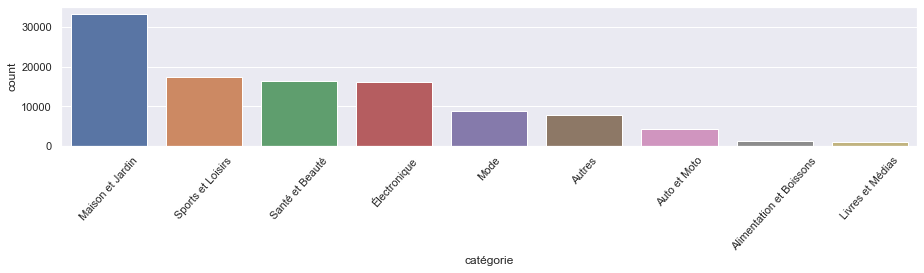

In [93]:
# Utiliser seaborn pour tracer la distribution des catégories
plt.figure(figsize=(13,4))
sns.countplot(x="catégorie", data=customer_purchase_info,order=customer_purchase_info['catégorie'].value_counts().sort_values(ascending=False).index)
# Tracer la distribution des catégories
#plt.xticks(rotation=45)
sns.set(style="darkgrid")
plt.xticks(rotation=48)
plt.tight_layout()  # Ajouter cette ligne

plt.show()

Les produits de la catégorie "Maison et jardin", "sport et Loisirs", "santé et Beauté" sont les plus achetés.

In [94]:
# Utiliser la méthode get_dummies pour transformer la colonne catégories en variables binaires
categorie_encoded= pd.get_dummies(customer_purchase_info["catégorie"])

# Concaténer les variables binaires avec le tableau de données original
customer_purchase_info_encd = pd.concat([customer_purchase_info, categorie_encoded], axis=1)

In [95]:
customer_purchase_info_encd

customer_id                customer_unique_id  \
0       06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1       97ee81fede5757f1ab031e83d1a59f56  452fab1c62b178922fc011b0eb89c1b9   
2       97ee81fede5757f1ab031e83d1a59f56  452fab1c62b178922fc011b0eb89c1b9   
3       44e25679aa4d5d2ef5103f6b0174a586  613259d64ba972e49dc25b019b7918c3   
4       ac318397fb90e64c9a724a3fc61ef587  aaad33c5051196b5e73c7d65b9072e1d   
...                                  ...                               ...   
114552  d1b1ef27bb2fbdeedc8823febfcc4072  20120882a566b99eb67c104dc05d896f   
114553  7dcd626576af9555424051dbdb01cb5a  7c0b4f7719caf8b29a4c8dbd5a1446c9   
114554  ec5f9c9dd3ff056f05411979267887a5  640ac18151727c99757e30b92253dbc0   
114555  7fb62e47282b83f023cf1fef8d8309c9  48f2f72862e37acc97f50b4484ee2af4   
114556  0b7a30ba373aeb55cf28add5b5477956  8c8173e547e020f411aa55b2fceed861   

        customer_zip_code_prefix customer_city customer_state   latitude  \
0                          14409        franca             SP -20.513713   
1                          47800     barreiras             BA -12.147031   
2                          47800     barreiras             BA -12.147031   
3                           6414       barueri             SP -23.495901   
4                          37137       alfenas             MG -21.407572   
...                          ...           ...            ...        ...   
114552                      9336          maua             SP -23.659848   
114553                     77370    natividade             TO -11.709159   
114554                      5315     sao paulo             SP -23.532950   
114555                      4319     sao paulo             SP -23.647471   
114556                     87145      paicandu             PR -23.501992   

        longitude                          order_id order_status  \
0      -47.396644  00e7ee1b050b8499577073aeb2a297a1    delivered   
1      -44.996092  a4866dfc455353f48014a2b9a86608a2    delivered   
2      -44.996092  a4866dfc455353f48014a2b9a86608a2    delivered   
3      -46.874687  03afb3c10af52ddfa3c33b9881bf43f8    delivered   
4      -45.943353  3c75044db750a89606612ed286713eb8    delivered   
...           ...                               ...          ...   
114552 -46.410127  435361f134c9396bdb0de6ed227fd883    delivered   
114553 -47.725555  9a142fefa71ded6bdc21817299f5ab7c    delivered   
114554 -46.731394  f50852b20857fd7ff56126315745e45a    delivered   
114555 -46.636862  c456339d894d329ad45d39e3d6796b90    delivered   
114556 -52.150755  e12f5458c6b4f349a97fbf22e08d17ac    delivered   

       order_purchase_timestamp  ...          catégorie  \
0           2017-05-16 15:05:35  ...             Autres   
1           2018-01-11 16:47:03  ...             Autres   
2           2018-01-11 16:47:03  ...             Autres   
3           2017-12-07 16:41:50  ...             Autres   
4           2018-03-13 20:11:20  ...             Autres   
...                         ...  ...                ...   
114552      2017-07-09 15:17:43  ...   Maison et Jardin   
114553      2018-06-11 16:10:21  ...  Sports et Loisirs   
114554      2018-04-29 17:40:51  ...   Maison et Jardin   
114555      2017-10-17 21:50:00  ...   Maison et Jardin   
114556      2017-08-01 12:57:02  ...       Auto et Moto   

       Alimentation et Boissons Auto et Moto Autres  Livres et Médias  \
0                             0            0      1                 0   
1                             0            0      1                 0   
2                             0            0      1                 0   
3                             0            0      1                 0   
4                             0            0      1                 0   
...                         ...          ...    ...               ...   
114552                        0            0      0                 0   
114553                        0            0      0                 0

Catégorie des produit

In [96]:
cat = categorie_encoded.columns
cat

Index(['Alimentation et Boissons', 'Auto et Moto', 'Autres',
       'Livres et Médias', 'Maison et Jardin', 'Mode', 'Santé et Beauté',
       'Sports et Loisirs', 'Électronique'],
      dtype='object')

In [97]:
categorie_produit =  customer_purchase_info_encd[['Alimentation et Boissons', 'Auto et Moto', 'Autres',
                                    'Livres et Médias', 'Maison et Jardin', 'Mode', 'Santé et Beauté',
                                    'Sports et Loisirs', 'Électronique','customer_unique_id']].groupby('customer_unique_id')\
                                    .sum()\
                                    .reset_index()
categorie_produit  #Table 5 : a ajouter dans la table finale

customer_unique_id  Alimentation et Boissons  \
0      0000366f3b9a7992bf8c76cfdf3221e2                         0   
1      0000b849f77a49e4a4ce2b2a4ca5be3f                         0   
2      0000f46a3911fa3c0805444483337064                         0   
3      0000f6ccb0745a6a4b88665a16c9f078                         0   
4      0004aac84e0df4da2b147fca70cf8255                         0   
...                                 ...                       ...   
92496  fffcf5a5ff07b0908bd4e2dbc735a684                         0   
92497  fffea47cd6d3cc0a88bd621562a9d061                         0   
92498  ffff371b4d645b6ecea244b27531430a                         0   
92499  ffff5962728ec6157033ef9805bacc48                         0   
92500  ffffd2657e2aad2907e67c3e9daecbeb                         0   

       Auto et Moto  Autres  Livres et Médias  Maison et Jardin  Mode  \
0                 0       0                 0                 1     0   
1                 0       0                 0                 0     0   
2                 0       0                 0                 0     0   
3                 0       0                 0                 0     0   
4                 0       0                 0                 0     0   
...             ...     ...               ...               ...   ...   
92496             0       0                 0                 0     0   
92497             0       0                 0                 0     0   
92498             1       0                 0                 0     0   
92499             0       0                 0                 0     1   
92500             0       0                 0                 0     0   

       Santé et Beauté  Sports et Loisirs  Électronique  
0                    0                  0             0  
1                    1                  0             0  
2                    0                  0             0  
3                    0                  0             1  
4                    0                  0             1  
...                ...                ...           ...  
92496                2                  0             0  
92497                1                  0             0  
92498                0                  0             0  
92499                0                  0             0  
92500                1                  0             0  

[92501 rows x 10 columns]

In [98]:
categorie_produit['Alimentation et Boissons'].value_counts()

0     91571
1       799
2        90
4        17
3        14
5         5
6         2
8         2
10        1
Name: Alimentation et Boissons, dtype: int64

#### Création du jeu de données final

In [99]:
data_model = segment_rfm.merge(note_com, on='customer_unique_id', how='inner')  # Ajout de la note donnée par le client
data_model = data_model.merge(frais_livraison, on='customer_unique_id', how='inner')
data_model = data_model.merge(t_moyen_livraison, on='customer_unique_id', how='inner')
data_model = data_model.merge(categorie_produit, on='customer_unique_id', how='inner')

data_model

customer_unique_id  recency  frequency  monetary  \
0      0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19   
2      0000f46a3911fa3c0805444483337064      536          1     86.22   
3      0000f6ccb0745a6a4b88665a16c9f078      320          1     43.62   
4      0004aac84e0df4da2b147fca70cf8255      287          1    196.89   
...                                 ...      ...        ...       ...   
92496  fffcf5a5ff07b0908bd4e2dbc735a684      446          2   4134.84   
92497  fffea47cd6d3cc0a88bd621562a9d061      261          1     84.58   
92498  ffff371b4d645b6ecea244b27531430a      567          1    112.46   
92499  ffff5962728ec6157033ef9805bacc48      118          1    133.69   
92500  ffffd2657e2aad2907e67c3e9daecbeb      483          1     71.56   

       note_com  frais_livraison  temps_moyen_livraison  \
0           5.0            12.00                    6.0   
1           4.0             8.29                    3.0   
2           3.0            17.22                   25.0   
3           4.0            17.63                   20.0   
4           5.0            16.89                   13.0   
...         ...              ...                    ...   
92496       5.0           248.71                   27.0   
92497       4.0            19.69                   30.0   
92498       5.0            22.56                   14.0   
92499       5.0            18.69                   11.0   
92500       5.0            14.57                    7.0   

       Alimentation et Boissons  Auto et Moto  Autres  Livres et Médias  \
0                             0             0       0                 0   
1                             0             0       0                 0   
2                             0             0       0                 0   
3                             0             0       0                 0   
4                             0             0       0                 0   
...                         ...           ...     ...               ...   
92496                         0             0       0                 0   
92497                         0             0       0                 0   
92498                         0             1       0                 0   
92499                         0             0       0                 0   
92500                         0             0       0                 0   

       Maison et Jardin  Mode  Santé et Beauté  Sports et Loisirs  \
0                     1     0                0                  0   
1                     0     0                1                  0   
2                     0     0                0                  0   
3                     0     0                0                  0   
4                     0     0                0                  0   
...                 ...   ...              ...                ...   
92496                 0     0                2                  0   
92497                 0     0                1                  0   
92498                 0     0                0                  0   
92499                 0     1                0                  0   
92500                 0     0                1                  0   

       Électronique  
0                 0  
1                 0  
2                 0  
3                 1  
4                 1  
...             ...  
92496             0  
92497             0  
92498             0  
92499             0  
92500             0  

[92501 rows x 16 columns]

In [100]:
data_model.isnull().sum()

customer_unique_id          0
recency                     0
frequency                   0
monetary                    0
note_com                    0
frais_livraison             0
temps_moyen_livraison       8
Alimentation et Boissons    0
Auto et Moto                0
Autres                      0
Livres et Médias            0
Maison et Jardin            0
Mode                        0
Santé et Beauté             0
Sports et Loisirs           0
Électronique                0
dtype: int64

In [101]:
data_model.shape

(92501, 16)

In [102]:
data_model[data_model["temps_moyen_livraison"].isnull()]

customer_unique_id  recency  frequency  monetary  \
7019   13467e882eb3a701826435ee4424f2bd      273          1    134.83   
8516   175378436e2978be55b8f4316bce4811       62          1     54.97   
10132  1bd06a0c0df8b23dacfd3725d2dc0bb9       58          1    158.07   
17095  2f17c5b324ad603491521b279a9ff4de       70          1    354.24   
21667  3bc508d482a402715be4d5cf4020cc81       58          1    158.07   
74122  cce5e8188bf42ffb3bb5b18ff58f5965       82          1    120.12   
77971  d77cf4be2654aa70ef150f8bfec076a6      460          1    194.00   
85362  ebf7e0d43a78c81991a4c59c145c75db       58          1    204.62   

       note_com  frais_livraison  temps_moyen_livraison  \
7019        5.0            17.53                    NaN   
8516        5.0             9.07                    NaN   
10132       5.0            19.07                    NaN   
17095       5.0            25.24                    NaN   
21667       5.0            19.07                    NaN   
74122       1.0             9.13                    NaN   
77971       5.0            15.00                    NaN   
85362       5.0            15.63                    NaN   

       Alimentation et Boissons  Auto et Moto  Autres  Livres et Médias  \
7019                          0             1       0                 0   
8516                          0             0       0                 1   
10132                         0             0       0                 0   
17095                         0             0       1                 0   
21667                         0             0       0                 0   
74122                         0             0       0                 0   
77971                         0             0       0                 0   
85362                         0             0       0                 0   

       Maison et Jardin  Mode  Santé et Beauté  Sports et Loisirs  \
7019                  0     0                0                  0   
8516                  0     0                0                  0   
10132                 0     1                0                  0   
17095                 0     0                0                  0   
21667                 0     1                0                  0   
74122                 0     0                0                  0   
77971                 0     0                0                  1   
85362                 0     0                0                  1   

       Électronique  
7019              0  
8516              0  
10132             0  
17095             0  
21667             0  
74122             1  
77971             0  
85362             0

In [103]:
data_model = data_model.dropna()

In [104]:
segment_rfm.columns

Index(['customer_unique_id', 'recency', 'frequency', 'monetary'], dtype='object')

In [105]:
data_model.columns

Index(['customer_unique_id', 'recency', 'frequency', 'monetary', 'note_com',
       'frais_livraison', 'temps_moyen_livraison', 'Alimentation et Boissons',
       'Auto et Moto', 'Autres', 'Livres et Médias', 'Maison et Jardin',
       'Mode', 'Santé et Beauté', 'Sports et Loisirs', 'Électronique'],
      dtype='object')

In [106]:
segment_rfm.to_csv("segment_rfm.csv", index=False)

In [107]:
data_model.to_csv('data_cleaned.csv', index=False)